In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Apresentação do dataset

* O conjunto de dados foi extraído de 800 imagens da "Bíblia de Ávila". Foi constatado que houve a presença de 12 copistas na escrita da bíblia em que
as páginas escritas por cada copista não são igualmente numerosas. Cada padrão contém 10 características.

* O modelo que deve ser criado consiste em associar cada padrão de escrita a um dos 12 copistas (rotulados como: A, B, C, D, E, F, G, H, I, W, X, Y).


#Obtenção e análise dos dados

## Importando dependências

In [ ]:
from google.colab import files
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from numpy import unique
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Importando os datasets

### Dataset de treinamento: avila-tr.txt

In [ ]:
# labels das features
labels = ["intercolumnar distance","upper margin","lower margin","exploitation","row number","modular ratio","interlinear spacing","weight","peak number","modular ratio/ interlinear spacing","Class"]
# labels das classes
classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "W", "X", "Y"]

path_dataset_train = "avila-tr.txt"

avila_train = pd.read_csv(path_dataset_train, sep=",",header=None,names=labels)

### Dataset de teste: avila-ts.txt

In [ ]:
path_dataset_test = "avila-ts.txt"

avila_test = pd.read_csv(path_dataset_test, sep=",",header=None,names=labels)



## Visualização de parte do dataset pelo Pandas

In [ ]:
# Dataset de Treinamento
avila_train.head()

# Dataset de Teste
avila_test.head()

,intercolumnar distance,upper margin,lower margin,exploitation,row number,modular ratio,interlinear spacing,weight,peak number,modular ratio/ interlinear spacing,Class
0,-3.498799,0.250492,0.232070,1.224178,-4.922215,1.145386,0.182426,-0.165983,-0.123005,1.087144,W
1,0.204355,-0.354049,0.320980,0.410166,-0.989576,-2.218127,0.220177,0.181844,2.090879,-2.009758,A
2,0.759828,-1.304042,-0.023991,-0.973663,-0.006417,-0.349509,-0.421580,-0.450127,0.469443,0.060952,I
3,-0.005490,0.360409,0.281860,-0.213479,-1.168333,-1.013906,-0.346080,1.176165,0.968347,-0.627999,E
4,0.080916,0.101320,0.104040,0.140490,0.261718,0.480988,0.710932,-0.253430,-0.497183,0.155681,A




## Analisando as variáveis
*   A nossa variável alvo (target vector) é a **Class** que corresponde a associação de cada padrão para um dos 12 copistas, representados pelas letras: A, B, C, D, E, F, G, H, I, W, X, Y. 


* O conjunto de recursos projetados para distinção de escriba pode ser dividido em três grupos, principalmente no que diz respeito ao layout da página ou à interação entre a caligrafia e o espaço disponível na página

### Primeiro grupo - propriedades geométricas de toda a página


*  O atributo **Intercolumnar Distance** indica a distância intercolunar que é utilizada por um copista na hora de sua escrita, é uma avaliação feita de forma vertical
*  O atributo **Upper Margin** indica a margem superior dada por um copista
*  O atributo **Lower Margin** indica a margem inferior dada por um copista

* As features desse grupo não são muito
distintas para um copista individual, mas pode ser muito útil para destacar diferenças cronológicas e/ou tipológicas

### Segundo grupo - Exploração de cada coluna na área escrita

* O atributo **Exploitation** é medido através de um coeficiente que calcula o quanto a coluna pega como amostra está preenchida de tinta

* O atributo **Row Number** indica o número de linhas que contém na coluna que foi pega como amostra na área de escrita

* Nesse segundo grupo, tais características podem ser
considerado como uma medida da habilidade do escritor e pode ser muito útil para distinção de escriba.


### Terceiro grupo - Forma como o escriba distribuía o texto em cada linha

* O atributo **Weight** informa o quanto a linha está preenchida com tinta (medida de espessura do traço)

* O atributo **Peak number** é uma estimativa razoável do número de caracteres em uma linha

* O atributo **Modular Ratio** é uma taxa que calcula o tamanho horizontal pelo tamanho vertical de um caractere (largura/altura)

* O atributo **Interlinear Spacing** informa o espaço que é dado entre as linhas 

* O atributo **Modular Ratio/Interlinear Spacing Ratio** é uma taxa que é obtida dividindo-se esses 2 parâmetros previamente especificados

* As features desse grupo caracterizam a maneira
de escrita adotada por um único escriba em um contexto específico, mas podem também sugerir distinções geográficas e/ou cronológicas

## Analisando o dataset


Obtendo informações mais detalhadas sobre as colunas (tipo e contagem) para o dataset de treinamento

In [ ]:
avila_train.info()
avila_train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   intercolumnar distance              10430 non-null  float64
 1   upper margin                        10430 non-null  float64
 2   lower margin                        10430 non-null  float64
 3   exploitation                        10430 non-null  float64
 4   row number                          10430 non-null  float64
 5   modular ratio                       10430 non-null  float64
 6   interlinear spacing                 10430 non-null  float64
 7   weight                              10430 non-null  float64
 8   peak number                         10430 non-null  float64
 9   modular ratio/ interlinear spacing  10430 non-null  float64
 10  Class                               10430 non-null  object 
dtypes: float64(10), object(1)
memory usage: 8

(10430, 11)

Pode-se observar que o nosso dataset possui 10430 linhas e 11 colunas

Faremos o mesmo para o dataset de teste

In [ ]:
avila_test.info()
avila_test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   intercolumnar distance              10437 non-null  float64
 1   upper margin                        10437 non-null  float64
 2   lower margin                        10437 non-null  float64
 3   exploitation                        10437 non-null  float64
 4   row number                          10437 non-null  float64
 5   modular ratio                       10437 non-null  float64
 6   interlinear spacing                 10437 non-null  float64
 7   weight                              10437 non-null  float64
 8   peak number                         10437 non-null  float64
 9   modular ratio/ interlinear spacing  10437 non-null  float64
 10  Class                               10437 non-null  object 
dtypes: float64(10), object(1)
memory usage: 8

(10437, 11)

Vê-se que o dataset de teste tem os atributos idênticos ao dataset de treino (como esperado) e possui 10437 linhas (exemplos)

Verificando se possui valores ausentes para que possam ser tratados

In [ ]:
# ordenar em ordem decrescente as variáveis por seus valores ausentes
(avila_train.isnull().sum() / avila_train.shape[0]).sort_values(ascending=False)

intercolumnar distance                0.0
upper margin                          0.0
lower margin                          0.0
exploitation                          0.0
row number                            0.0
modular ratio                         0.0
interlinear spacing                   0.0
weight                                0.0
peak number                           0.0
modular ratio/ interlinear spacing    0.0
Class                                 0.0
dtype: float64

In [ ]:
avila_train.isna().any()

intercolumnar distance                False
upper margin                          False
lower margin                          False
exploitation                          False
row number                            False
modular ratio                         False
interlinear spacing                   False
weight                                False
peak number                           False
modular ratio/ interlinear spacing    False
Class                                 False
dtype: bool

Pela nossa análise é possível constatar que nosso dataset não possui valores ausentes

Vamos agora fazer o mesmo para o dataset de teste

In [ ]:
# ordenar em ordem decrescente as variáveis por seus valores ausentes
(avila_test.isnull().sum() / avila_test.shape[0]).sort_values(ascending=False)


intercolumnar distance                0.0
upper margin                          0.0
lower margin                          0.0
exploitation                          0.0
row number                            0.0
modular ratio                         0.0
interlinear spacing                   0.0
weight                                0.0
peak number                           0.0
modular ratio/ interlinear spacing    0.0
Class                                 0.0
dtype: float64

In [ ]:
avila_test.isna().any()

intercolumnar distance                False
upper margin                          False
lower margin                          False
exploitation                          False
row number                            False
modular ratio                         False
interlinear spacing                   False
weight                                False
peak number                           False
modular ratio/ interlinear spacing    False
Class                                 False
dtype: bool

Idêntico ao dataset de treino

Vamos agora verificar como está o balanceamento do nosso dataset levando em consideração a variável alvo de ambos os datasets. Primeiro faremos para o dataset de treinamento.

A    4286
F    1961
E    1095
I     831
X     522
H     519
G     446
D     352
Y     266
C     103
W      44
B       5
Name: Class, dtype: int64


<AxesSubplot:xlabel='Class', ylabel='count'>

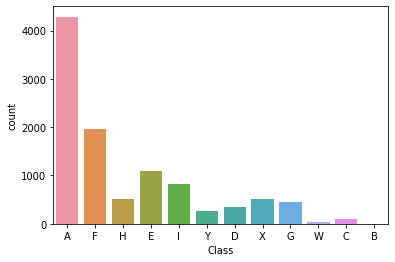

In [ ]:
v = avila_train.Class.value_counts()
print(v)

sns.countplot(x='Class', data = avila_train)

Agora aplicamos ao dataset de teste

A    4286
F    1962
E    1095
I     832
X     522
H     520
G     447
D     353
Y     267
C     103
W      45
B       5
Name: Class, dtype: int64


<AxesSubplot:xlabel='Class', ylabel='count'>

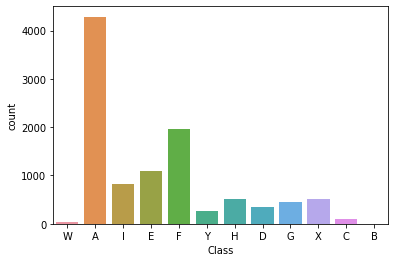

In [ ]:
v = avila_test.Class.value_counts()
print(v)

sns.countplot(x='Class', data = avila_test)

Podemos observar a partir da nossa análise que o nosso dataset possui classes com muitos exemplos e algumas classes possuem pouquíssimos, podendo destacar a classe B que é aque possui menos exemplos (5 exemplos). Além disso podemos observar que a quantidade de exemplos no dataset de treinamento e teste para cada classe são similares.

Podemos usar agora a matriz de correlação ao nosso favor para checar a correlação entre as features

<AxesSubplot:>

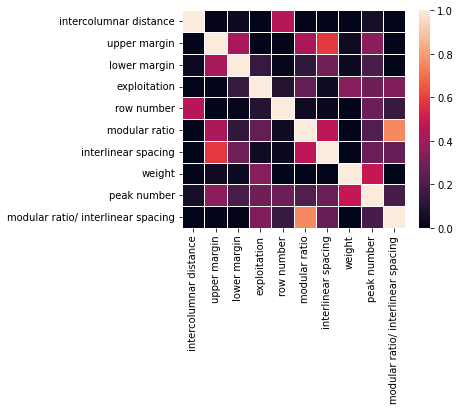

In [ ]:
corr = avila_train.corr()
fig = plt.figure(figsize=(5,4))
sns.heatmap(corr, vmin=0, vmax=1, linewidths=.5)

  * Podemos constatar que há uma correlação maior entre peak number e weight além de modular ratio e modular ratio/interlinear spacing (como já foi apontado na descrição dos atributos). Podemos também tirar como conclusão que apesar da divisão ser entre os atributos modular ratio e interlinear spacing, o atributo de modular ratio influencia mais, sendo mais discriminante. Outra correlação que podemos constatar é a de interlinear spacing e upper margin.

## Setando a seed do gerador de números aleatórios

Dessa forma os resultados obtidos pelo modelo não serão diferentes para diferentes sessões

In [ ]:
SEED = 32642
np.random.seed(SEED)

## Dividindo dataset de treinamento e teste em: features e classes

In [ ]:
# Features de treinamento
X_train = avila_train.drop(['Class'], axis = 1)

# Classes de treinamento
y_train = avila_train['Class']

print("Dataset de treinamento")
print("Tamanho do dataset de features = ", X_train.shape)
print("Tamanho do dataset de classes = ", y_train.shape)

Dataset de treinamento
Tamanho do dataset de features =  (10430, 10)
Tamanho do dataset de classes =  (10430,)


In [ ]:
# Features de teste
X_test = avila_test.drop(['Class'], axis = 1)

# Classes de teste
y_test = avila_test['Class']

print("Dataset de teste")
print("Tamanho do dataset de features = ", X_test.shape)
print("Tamanho do dataset de classes = ", y_test.shape)

Dataset de teste
Tamanho do dataset de features =  (10437, 10)
Tamanho do dataset de classes =  (10437,)


# Classificação usando Árvore de Decisão


## Bibliotecas e referências usadas

- scikit-learn
  - sklearn.tree
    - [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
    - [Post pruning decision trees with cost complexity pruning](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)
  - sklearn.model_selection
    - train_test_split
    - [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
  - sklearn.metrics
    - accuracy_score
    - [precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)
    - [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
    - confusion_matrix
    - [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)
- pandas
- numpy
- matplotlib

## Modelo padrão de árvore de decisão

Treinaremos o modelo usando o parâmetro de random_state com o valor da SEED.

Após isso, obteremos os resultados preditos do treinamento usando o dataset de teste.

In [ ]:
dtc = DecisionTreeClassifier(random_state = SEED)
dtc.fit(X_train, y_train)

predicted = dtc.predict(X_test)
predicted

array(['W', 'A', 'A', ..., 'A', 'F', 'H'], dtype=object)

Obtivemos nosso array de predições, agora, vamos analisar quantos desses resultados nosso modelo acertou.

### Análises

#### Resultados numéricos:

- Para cada classe:
  - Precisão
  - Recall
  - F1 Score
- Acurácia
- Médias macro e weighted:
  - Precisão
  - Recall
  - F1 Score

Com o classification_report, comparamos o array de elementos preditos com o array dos elementos reais do dataset de teste.

In [ ]:
cr = classification_report(predicted, y_test, digits=4)

print(f'Classification report: \n{cr}')

Classification report: 
              precision    recall  f1-score   support

           A     0.9809    0.9800    0.9804      4290
           B     1.0000    1.0000    1.0000         5
           C     0.9806    0.9528    0.9665       106
           D     0.9717    0.9608    0.9662       357
           E     0.9443    0.9478    0.9460      1091
           F     0.9745    0.9795    0.9770      1952
           G     0.9620    0.9685    0.9652       444
           H     0.9635    0.9364    0.9498       535
           I     0.9832    0.9855    0.9844       830
           W     0.9556    0.8431    0.8958        51
           X     0.9176    0.9283    0.9229       516
           Y     0.9288    0.9538    0.9412       260

    accuracy                         0.9694     10437
   macro avg     0.9635    0.9530    0.9580     10437
weighted avg     0.9695    0.9694    0.9694     10437



Resultados para cada classe:
- Percebemos uma boa média geral nos valores do Precision Score, com todas acima de 0.9, ressaltando o resultado perfeito para a classe "B".
- Para os resultados de Recall Score e F1-Score, os resultados foram semelhantes aos do Precision Score, exceto para a classe "W" que obteve resultados abaixo de 0.9 para o Recall e F1-Score, provavelmente, por uma alta quantidade de Falsos Negativos no cálculo.

Resultados gerais:
- Obtivemos uma acurácia satisfatória de ~0.97.
- Também obtivemos médias macro satisfatórias de Precision = ~0.96, Recall = ~0.95 e F1-Score = ~0.96.

#### Matriz de confusão

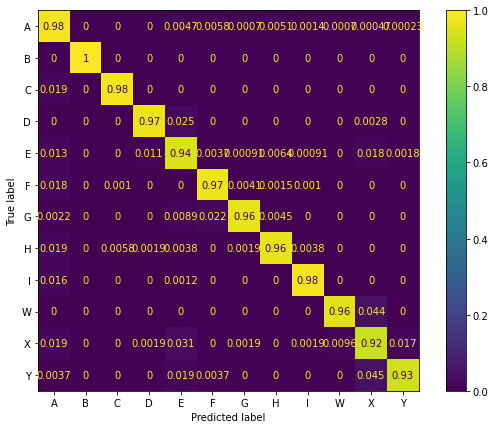

In [ ]:
cm = confusion_matrix(y_test, predicted, labels=classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)

fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax)

plt.show()

Podemos perceber que houve um desempenho relativamente pior em distinguir as classes E, W, X e Y.

## Otimização do modelo usando GridSearchCV


Código de referência: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Parâmetros que atualizaremos no GridSearchCV para o DecisionTreeClassifier:
- criterion: função que mede a qualidade do split dos nós.
  - gini: para a Gini impurity;
  - log_loss e entropy: ambos para o ganho de informação Shannon.
- splitter: estratégia usada para separar cada nó.
  - best: escolhe o melhor split;
  - random: escolhe o melhor split aleatório.
- max_depth: profundidade máxima da árvore.
- ccp_alpha: custo de complexidade que permite realizar um método de poda da árvore, o Minimal Cost-Complexity Pruning (post prunning). A sub-árvore com o maior custo de complexidade que é menor que ccp_alpha será escolhida.
  - 0.0: sem poda.
- random_state: controla a aleatoriedade do estimador.
  - Usaremos a nossa Seed setada previamente.

O GridSearchCV também possui integrado um Cross-Validation, através do parâmetro cv.
- Usaremos 5 folds para o Cross-Validation do modelo, assim permitindo com que pelo menos um elemento da classe B fique em cada fold.

In [ ]:
dtc = DecisionTreeClassifier()

params = {'criterion':['gini', 'entropy', 'log_loss'], 
          'splitter':['best','random'],
          'max_depth':[None, 2, 5, 10, 15, 20],
          'ccp_alpha':[0.0, 0.0000001, 0.00001, 0.001, 0.01, 0.1, 0.5, 0.75],
          'random_state': [SEED]}

gs_dtc = GridSearchCV(dtc, params, cv=5, refit=True)

Agora, vamos treinar o modelo com o GridSearchCV e após isso pegar os melhores parâmetros.

In [ ]:
gs_dtc.fit(X_train, y_train)
gs_dtc.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'max_depth': None,
 'random_state': 32642,
 'splitter': 'best'}

Agora, vamos treinar um novo modelo de árvore de decisão utilizando os melhores parâmetros obtidos com o GridSearchCV.

In [ ]:
best_dtc = DecisionTreeClassifier()
best_dtc.set_params(**gs_dtc.best_params_)
best_dtc.fit(X_train, y_train)

best_predicted = best_dtc.predict(X_test)
best_predicted

array(['W', 'A', 'I', ..., 'A', 'F', 'H'], dtype=object)

Agora, com o array dos resultados preditos com as features de teste para o melhor modelo do GridSearchCV, vamos comparar com os resultados esperados do dataset de teste.

### Análises do melhor modelo do GridSearchCV

#### Resultados numéricos:

- Para cada classe:
  - Precisão
  - Recall
  - F1 Score
- Acurácia
- Médias macro e weighted:
  - Precisão
  - Recall
  - F1 Score

In [ ]:
cr = classification_report(best_predicted, y_test, digits=4)

print(f'Classification report: \n{cr}')

Classification report: 
              precision    recall  f1-score   support

           A     0.9944    0.9949    0.9946      4284
           B     1.0000    1.0000    1.0000         5
           C     0.9806    0.9712    0.9758       104
           D     0.9688    0.9942    0.9813       344
           E     0.9781    0.9649    0.9714      1110
           F     0.9975    0.9924    0.9949      1972
           G     0.9508    0.9907    0.9703       429
           H     0.9788    0.9770    0.9779       521
           I     0.9988    1.0000    0.9994       831
           W     1.0000    0.9574    0.9783        47
           X     0.9579    0.9470    0.9524       528
           Y     0.9700    0.9885    0.9792       262

    accuracy                         0.9875     10437
   macro avg     0.9813    0.9815    0.9813     10437
weighted avg     0.9876    0.9875    0.9875     10437



Comparando resultados dos modelos Pré e Pós GridSearchCV.

---

Resultados para cada classe:
- Houve uma melhora satisfatória nos resultados de ambos Precision, Recall e F1-Score.
- A classe I no modelo otimizado pelo gridsearch acabou com 100% de acerto no teste para o Recall.
- A classe W que no modelo pré-gridsearch tinha resultados abaixo de 0.9 para o Recall e F1-Score, agora possui em todos os scores resultados acima de 0.9. E com a ressalva de que conseguiu 100% de acerto no teste para o Precision Score.
- A classe X agora ocupa o papel da classe com os menores scores, ainda que acima de 0.9.

Resultados gerais:
- Obtivemos uma melhora de ~0.97 para ~0.99 na acurácia.
- Os resultados para as médias macro também obtiveram uma melhora de:
  - Precision = ~0.96 para ~0.98;
  - Recall = ~0.95 para ~0.98;
  - F1-Score = ~0.96 para ~0.98.

#### Matriz de confusão

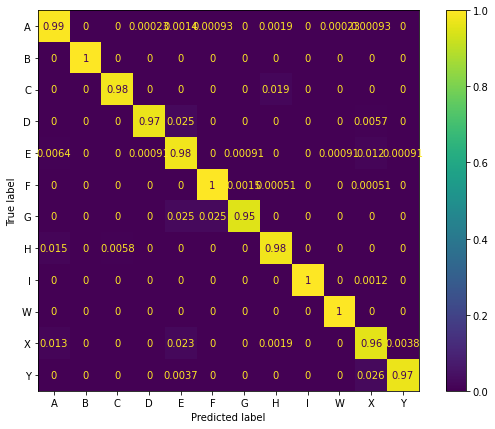

In [ ]:
cm = confusion_matrix(y_test, best_predicted, labels=classes, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)

fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax)

plt.show()

Podemos perceber visualmente a melhora geral na distinção das classes.

# Naive Bayes

Os classificadores Naive Bayes levam mão da seguinte modificação do teorema de Bayes 

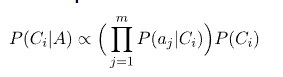


Isso significa que assumimos a indepêndencia entre as features (por isso o termo "naive"). Dessa forma, como vimos anteriormente que os atributos do dataset não são linearmente correlacionados, não será necessário realizar um tratamento especial para lidar com a correlação.

### Escolha do Classificador

Existem os seguintes classificadores Naive Bayes no scikit: 
- Gaussian
- Bernoulli
- Categorical
- Complement
- Multinomial

O classificador selecionado foi o Gaussian já que ele é apropriado para dados continuos, enquanto os outros são para outros tipos de dados (e.g. discreto, binário, etc...)

Entretanto, é importante observar que dada a natureza do Naive Bayes ele irá ter um baixo desempenho em datasets desbalanceados que é o caso do Avila. 

## Naive Bayes (Gaussian)

### Modelo Padrão

Primeiro treinaremos o modelo Gaussian com os valores padrões para determinar uma base que será utilizadas afim de comparar resultados e buscar melhorias.

In [ ]:
gauss = GaussianNB()
gauss.fit(X_train, y_train)
pred = gauss.predict(X_test) # Predizendo os dados de teste

#### Analise do modelo

##### Scores


In [ ]:
target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'W','X', 'Y']
report = classification_report(y_test, pred, target_names=target_names, digits=4)
print(report)

              precision    recall  f1-score   support

           A     0.5113    0.0635    0.1129      4286
           B     1.0000    1.0000    1.0000         5
           C     0.0468    0.0777    0.0584       103
           D     0.1517    0.2436    0.1870       353
           E     0.2565    0.0895    0.1327      1095
           F     0.2877    0.4190    0.3411      1962
           G     0.1538    0.7002    0.2522       447
           H     0.2162    0.8154    0.3418       520
           I     0.7249    0.6779    0.7006       832
           W     0.1237    0.5111    0.1991        45
           X     0.4637    0.6609    0.5450       522
           Y     0.4612    0.3783    0.4156       267

    accuracy                         0.2933     10437
   macro avg     0.3665    0.4698    0.3572     10437
weighted avg     0.4077    0.2933    0.2542     10437



No geral nota-se o baixo desempenho do modelo em relação a todos os scores (Precision, Recall, F1-score). 
Macro Average: 
- Precision = 0.37
- Recall = 0.47
- F1-Score = 0.36

Além disso, notasse uma grande disparidade entre os scores de cada classe.
- Para a classe A o precision é de 0.51 enquanto o recall e f1-score são relativamente menores, 0.06 e 0.11 respectivamente.
- Classes como I e B tiveram scores altos em relação a média dos scores das classes, mas para classes como a C desempenharam mal.

##### Matriz de Confusão

A matriz de confusão a seguir demonstra como o modelo se comportou tentando prever o conjunto de teste. 

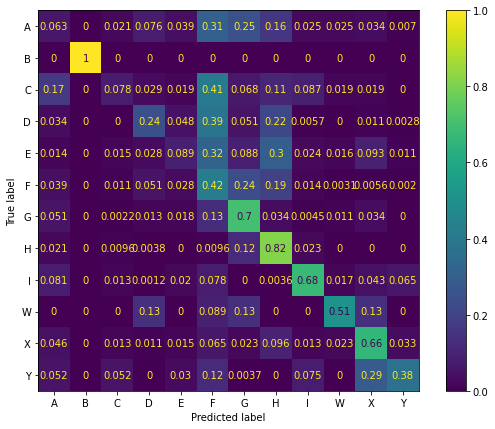

In [ ]:
cm = confusion_matrix(y_test, pred, labels=target_names, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)

fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax)

plt.show()

Nota-se uma dificuldade do modelo em predizer corretamente algumas classes
* A classe A é frequentemente confundida com a F e a G. 
* A classe C é frquentemente confudida com a F.

Equanto teve uma acurácia relativamente melhor em outras, à exemplo das classes H e I.

Adjunto, o modelo tende a prever frequentemente um exemplo como sendo pertencente da classe F.

### Fine-Tunning


Para realizar o fine-tunning do modelo iremos tentar achar os melhores hyper-parâmetros cujo o desempenho dos scores( Precision, F1, Recall) seja máximo.

O Gaussian apenas possui um hyper-parâmetro que é ***var_smoothing***.

> **O var_smoothing** é um valor entre 0 e 1 e indica a parte da maior variância de todos as features que são adicionadas às variâncias afim de estabilidade de cálculo. Possui valor padrão de 1e-9.

Para fazer a busca do melhor var_smoothing é feita um grid_search que utiliza dentro de seu processo a validação cruzada. Assim evitamos a bias de tunning com dataset de teste.

In [ ]:
search_space = np.linspace(1e-12,1, 10)
sc_scores_tr = []


gs = GridSearchCV(
    GaussianNB(),
    param_grid={'var_smoothing': search_space},
    scoring= ['precision_macro','recall_macro','f1_macro'],
    n_jobs=-1,
    refit=False,
    return_train_score=True,
    cv=5
)

gs.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e-12, 1.11111111e-01, 2.22222222e-01, 3.33333333e-01,
       4.44444444e-01, 5.55555556e-01, 6.66666667e-01, 7.77777778e-01,
       8.88888889e-01, 1.00000000e+00])},
             refit=False, return_train_score=True,
             scoring=['precision_macro', 'recall_macro', 'f1_macro'])

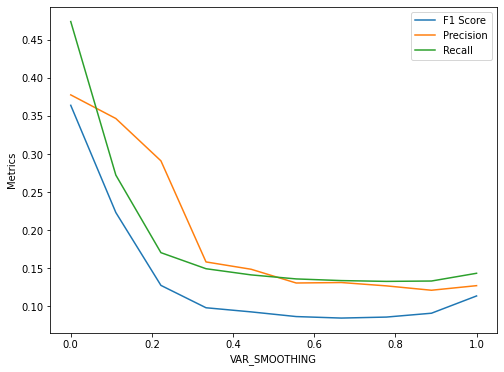

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlabel('VAR_SMOOTHING')
ax.set_ylabel('Metrics')

ax.plot(search_space, gs.cv_results_['mean_test_f1_macro'], label='F1 Score')
ax.plot(search_space, gs.cv_results_['mean_test_precision_macro'], label='Precision',)
ax.plot(search_space, gs.cv_results_['mean_test_recall_macro'], label='Recall',)

ax.legend()
plt.show()


É possível notar que todos os scores seguem a mesma tendência de piora inicial conforme o aumento do var_smoothing. 

É valido ressaltar que existe uma queda brusca para var_smoothing entre 0.0 e 0.2, seguida por uma estabilização para valores entre 0.2 e 0.9, para enfim ocorrer uma crescente de 0.9 a 1.0.

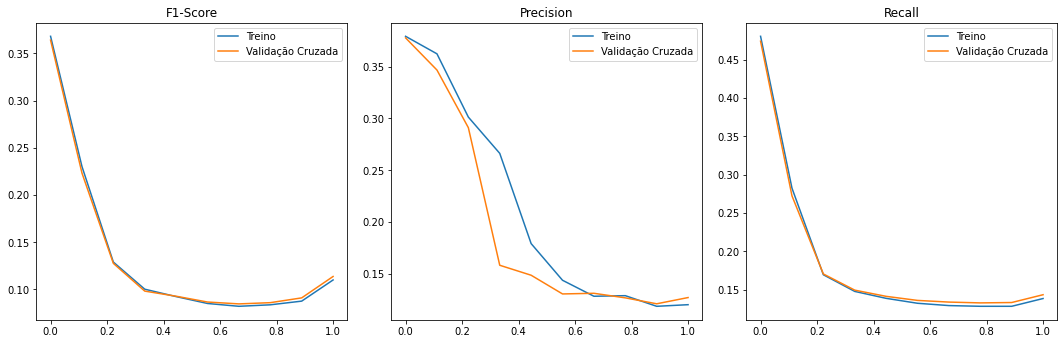

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(search_space,gs.cv_results_['mean_train_f1_macro'])
ax[0].plot(search_space,gs.cv_results_['mean_test_f1_macro'])

ax[1].plot(search_space,gs.cv_results_['mean_train_precision_macro'])
ax[1].plot(search_space,gs.cv_results_['mean_test_precision_macro'])

ax[2].plot(search_space,gs.cv_results_['mean_train_recall_macro'])
ax[2].plot(search_space,gs.cv_results_['mean_test_recall_macro'])

for i in range(0,3):
  ax[i].legend(('Treino','Validação Cruzada'))

ax[0].set_title('F1-Score')
ax[1].set_title('Precision')
ax[2].set_title('Recall')

fig.tight_layout(pad=1.5)
plt.show()  

Observando os gráficos vemos que não ocorre overfitting. 

Além disso, observamos também que quanto mais próximo de 0 é o var_smoothing, maior são os scores. 



#### Modelo Otimizado

Assim para realizar o fine-tunning do modelo selecionaremos 1e-12 já que esse é o melhor valor do processo de grid search.

In [ ]:
bestGaus = GaussianNB(var_smoothing=1e-12)
bestGaus.fit(X_train, y_train)
pred = bestGaus.predict(X_test)

target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'W','X', 'Y']
report = classification_report(y_test, pred, target_names=target_names, digits=4)
print(report)

              precision    recall  f1-score   support

           A     0.5113    0.0635    0.1129      4286
           B     1.0000    1.0000    1.0000         5
           C     0.0468    0.0777    0.0584       103
           D     0.1517    0.2436    0.1870       353
           E     0.2565    0.0895    0.1327      1095
           F     0.2877    0.4190    0.3411      1962
           G     0.1538    0.7002    0.2522       447
           H     0.2162    0.8154    0.3418       520
           I     0.7249    0.6779    0.7006       832
           W     0.1237    0.5111    0.1991        45
           X     0.4637    0.6609    0.5450       522
           Y     0.4612    0.3783    0.4156       267

    accuracy                         0.2933     10437
   macro avg     0.3665    0.4698    0.3572     10437
weighted avg     0.4077    0.2933    0.2542     10437



É possível notar a melhoria, apesar que mínima, em todos os scores quando comparado com o modelo padrão. 

É valido ressaltar que o naive bayes não terá no geral um bom desempenho pois o dataset está desbalanceado.

# Classificação usando Regressão Logística


## Bibliotecas usadas:
- scikit-learn (LogisticRegression)
  - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- pandas

O primeiro ponto importante a ser notado é que o problema em questão é de classificação multi-classe. O algoritmo de regressão logística consegue separar um dado entre 2 classes, tal como um problema de sim ou não. Assim, para um problema multi-classe, podemos tratar cada classe como um problema de classificação binária, ou seja, vamos comparar, para cada classe, se um dado pertence a ela ou não. Essa abordagem é conhecida como "método de um contra todos". Nessa abordagem, ao trabalharmos com uma classe, essa classe é denotada por 1 e as outras, por 0.

## Modelo base

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=32642)

### Teste

In [ ]:
model.score(X_test, y_test)

0.5309954967902654

In [ ]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           A     0.4957    0.9704    0.6562      4286
           B     1.0000    1.0000    1.0000         5
           C     0.0000    0.0000    0.0000       103
           D     0.0000    0.0000    0.0000       353
           E     0.4032    0.0685    0.1171      1095
           F     0.1923    0.0280    0.0489      1962
           G     0.0000    0.0000    0.0000       447
           H     0.4706    0.0769    0.1322       520
           I     0.8236    0.8810    0.8513       832
           W     0.0000    0.0000    0.0000        45
           X     0.8212    0.6686    0.7371       522
           Y     0.7412    0.4719    0.5767       267

    accuracy                         0.5310     10437
   macro avg     0.4123    0.3471    0.3433     10437
weighted avg     0.4316    0.5310    0.4175     10437



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


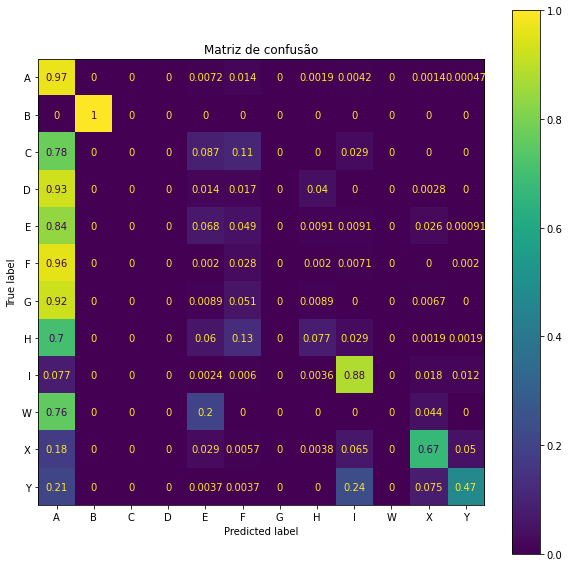

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize="true")
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Não tivemos um bom resultado. Para buscar os melhores parâmetros, vamos usar um grid search com cross validation.

## Grid search

In [ ]:
parameters = {'multi_class': ["ovr", "multinomial"], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}
log_reg = LogisticRegression(max_iter=1000, random_state=SEED)
log_reg_cv = GridSearchCV(estimator=log_reg, param_grid=parameters, cv=5, n_jobs=-1, scoring=['precision_macro','recall_macro','f1_macro'], refit=False)
log_reg_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=32642),
             n_jobs=-1,
             param_grid={'multi_class': ['ovr', 'multinomial'],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             refit=False,
             scoring=['precision_macro', 'recall_macro', 'f1_macro'])

In [ ]:
results_df = pd.DataFrame(log_reg_cv.cv_results_)
results_df[['mean_test_f1_macro','mean_test_recall_macro','mean_test_precision_macro', 'params']].head()

,mean_test_f1_macro,mean_test_recall_macro,mean_test_precision_macro,params
0,0.337121,0.345924,0.403675,"{'multi_class': 'ovr', 'solver': 'lbfgs'}"
1,0.337121,0.345924,0.403675,"{'multi_class': 'ovr', 'solver': 'newton-cg'}"
2,0.263750,0.266564,0.343546,"{'multi_class': 'ovr', 'solver': 'sag'}"
3,0.247812,0.253806,0.334808,"{'multi_class': 'ovr', 'solver': 'saga'}"
4,0.398664,0.398872,0.464567,"{'multi_class': 'multinomial', 'solver': 'lbfgs'}"


Analisando a tabela, é possível identificar que os melhores parâmetros são "multinomial" para "multi_class" e "lbfgs" para "solver. Vamos treinar um modelo base utilizando-os.

## Modelo com melhores parâmetros

Utilizando os melhores parâmetros testados pelo grid search, temos "multi_class" como "multinomial", o que significa que o algoritmo de treinamento usará "cross-entropy loss", e o parâmetro "solver" como "lbfgs".

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=32642)

### Teste

In [ ]:
model.score(X_test, y_test)

0.5613682092555332

In [ ]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           A     0.5303    0.9426    0.6787      4286
           B     1.0000    1.0000    1.0000         5
           C     0.0000    0.0000    0.0000       103
           D     0.0000    0.0000    0.0000       353
           E     0.5283    0.2475    0.3371      1095
           F     0.3676    0.0912    0.1462      1962
           G     0.0000    0.0000    0.0000       447
           H     0.4660    0.1846    0.2645       520
           I     0.8529    0.8714    0.8621       832
           W     0.2222    0.0444    0.0741        45
           X     0.7460    0.7088    0.7269       522
           Y     0.7008    0.6404    0.6693       267

    accuracy                         0.5614     10437
   macro avg     0.4512    0.3943    0.3966     10437
weighted avg     0.4902    0.5614    0.4777     10437



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


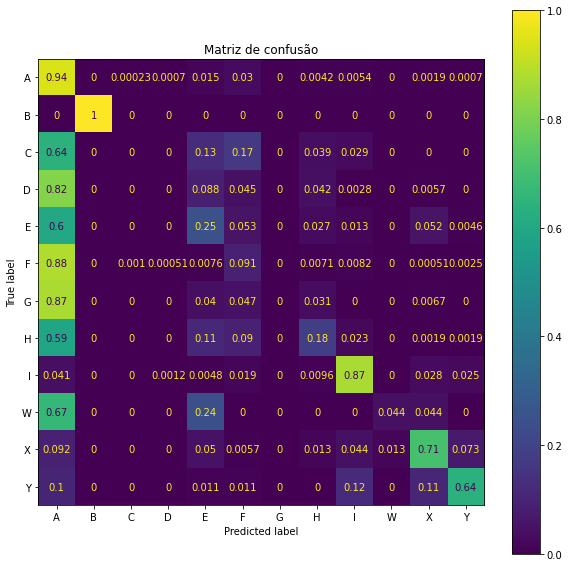

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize="true")
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Foi possível perceber que o modelo base errou todos das classes C, D e G, além de ter errado a maioria dos exemplos das classes E, F, H e W. Além disso, um fato muito interessante de se notar é que todas essas classes que não tiveram bons resultados foram confundidas com exemplos da classe A. Isso provavelmente aconteceu devido ao desbalanceamento do dataset, com muito mais dados da classe A. Assim, para a primeira tentativa de melhoria do modelo, vamos apenas diminuir a quantidade de exemplos da classe A e manter os outros parâmetros.

## Modelo com mudança no balanceamento do dataset

Para este modelo, vamos reduzir o número de exemplos da classe A.

In [ ]:
# Mudanças no dataset
balanced_dataset = avila_train.drop(avila_train.query("Class == 'A'").sample(frac=0.5).index)
balanced_dataset.shape

X_train_balanced = balanced_dataset.iloc[:, :-1]
y_train_balanced = balanced_dataset.iloc[:, -1]

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=32642)

### Teste

In [ ]:
model.score(X_test, y_test)

0.5474753281594328

In [ ]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           A       0.65      0.62      0.63      4286
           B       1.00      1.00      1.00         5
           C       0.00      0.00      0.00       103
           D       0.00      0.00      0.00       353
           E       0.49      0.44      0.46      1095
           F       0.34      0.61      0.44      1962
           G       0.00      0.00      0.00       447
           H       0.49      0.21      0.29       520
           I       0.84      0.87      0.86       832
           W       0.14      0.04      0.07        45
           X       0.71      0.71      0.71       522
           Y       0.69      0.65      0.67       267

    accuracy                           0.55     10437
   macro avg       0.45      0.43      0.43     10437
weighted avg       0.53      0.55      0.53     10437



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


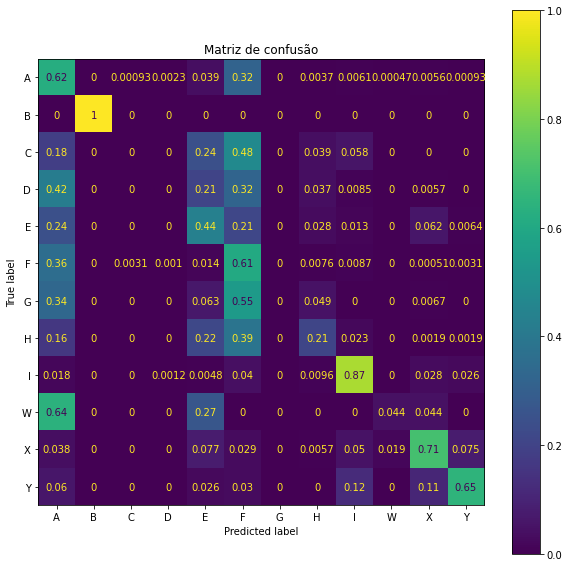

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

O resultado da classificação melhorou muito para algumas das classes, como a E e a F, mas ele piorou para a classe A. Observando as matrizes de confusão dos dois modelos testados até aqui, é possível inferir que as classes A e F estão gerando muitos problemas para a classificação. Isso pode estar acontecendo porque ambas as classes devem possuir exemplos muito próximos uns dos outros, dificultando sua separação. Vamos utilizar a técnica do PCA para identificar as features que melhor separam ambas as classes e utilizá-las para realizar a classificação.

## Modelo com mudança nas colunas do dataset

Inicialmente vamos tentar procurar formas de separar as classes A e F, a fim de melhorar a acurácia do modelo. Para isso, vamos tentar utilizar o PCA.

In [ ]:
avila_tr_A = avila_train.query("Class == 'A'")
avila_tr_F = avila_train.query("Class == 'F'")
avila_tr_A_F = pd.concat([avila_tr_A, avila_tr_F], axis=0)
avila_tr_A_F.shape

X_train_A_F = avila_tr_A_F.iloc[:, :-1]
y_train_A_F = avila_tr_A_F.iloc[:, -1]

### Análise utilizando PCA

Como os dados já estão normalizados, podemos partir para o "fit" e o "transform" no PCA

In [ ]:
principal = PCA(n_components=3)
principal.fit(X_train_A_F)
x = principal.transform(X_train_A_F)
x.shape

(6247, 3)

O número de features foi reduzida para 3. Com o PCA feito, podemos plotar um gráfico para verificar se os componentes principais conseguem separar as classes A e F.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train_A_F)
encoded_labels = le.transform(y_train_A_F)
encoded_labels

array([0, 0, 0, ..., 1, 1, 1])

Text(0, 0.5, 'pc2')

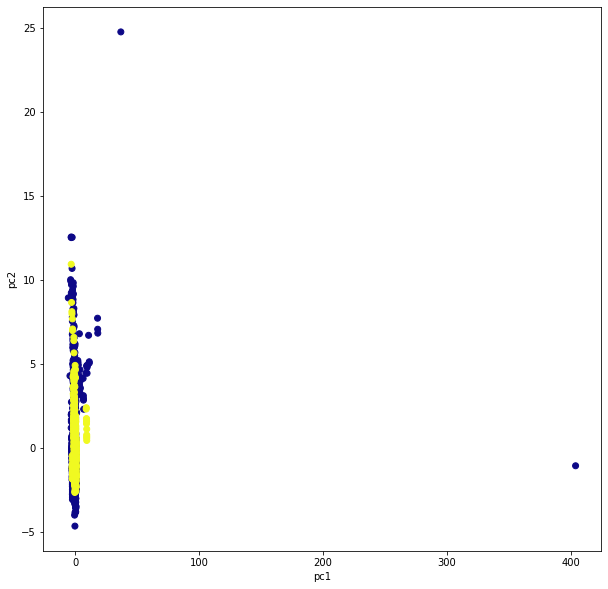

In [ ]:
plt.figure(figsize=(10,10))
colors = np.random.rand(6247)
plt.scatter(x=x[:,0], y=x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

Text(0.5, 0, 'PC3')

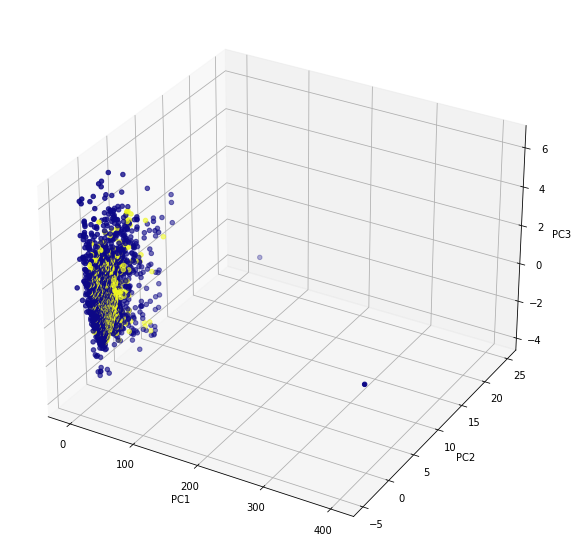

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=encoded_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

Utilizando o PCA foi possível ver que, mesmo utilizando os principais componentes para separar os dados, eles ainda não são bem separáveis. Assim, vamos tentar reduzir o número de features, mantendo as mais relevantes de acordo com o artigo que acompanha o projeto.

### Removendo colunas do dataset

In [ ]:
avila_tr_dropped = avila_train.drop(columns=["modular ratio/ interlinear spacing", "weight", "modular ratio", "interlinear spacing"])
avila_ts_dropped = avila_test.drop(columns=["modular ratio/ interlinear spacing", "weight", "modular ratio", "interlinear spacing"])

X_train_dropped = avila_tr_dropped.iloc[:, :-1]
y_train_dropped = avila_tr_dropped.iloc[:, -1]

X_test_dropped = avila_ts_dropped.iloc[:, :-1]
y_test_dropped = avila_ts_dropped.iloc[:, -1]

### Análise utilizando PCA para dataset com colunas removidas

Como os dados já estão normalizados, podemos partir para o "fit" e o "transform" no PCA

In [ ]:
avila_tr_A_dropped = avila_tr_dropped.query("Class == 'A'")
avila_tr_F_dropped = avila_tr_dropped.query("Class == 'F'")
avila_tr_A_F_dropped = pd.concat([avila_tr_A_dropped, avila_tr_F_dropped], axis=0)

X_train_A_F_dropped = avila_tr_A_F_dropped.iloc[:, :-1]
y_train_A_F_dropped = avila_tr_A_F_dropped.iloc[:, -1]

In [ ]:
principal = PCA(n_components=3)
principal.fit(X_train_A_F_dropped)
x = principal.transform(X_train_A_F_dropped)
x.shape

(6247, 3)

O número de features foi reduzida para 3. Com o PCA feito, podemos plotar um gráfico para verificar se os componentes principais conseguem separar as classes A e F.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train_A_F_dropped)
encoded_labels = le.transform(y_train_A_F_dropped)
encoded_labels

array([0, 0, 0, ..., 1, 1, 1])

Text(0, 0.5, 'pc2')

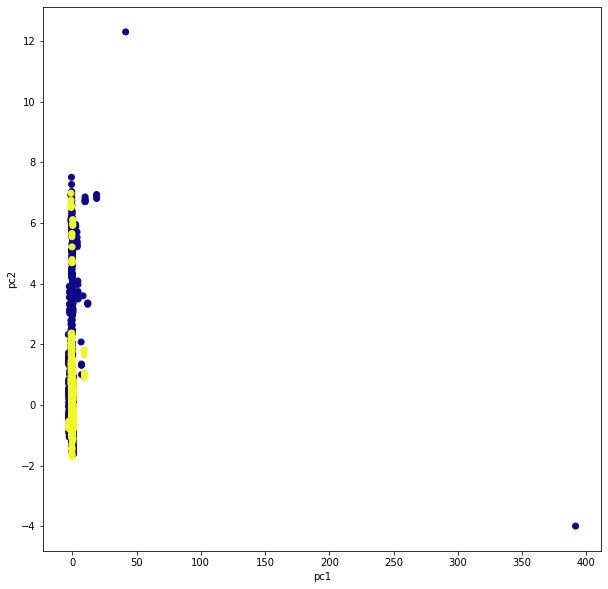

In [ ]:
plt.figure(figsize=(10,10))
colors = np.random.rand(6247)
plt.scatter(x=x[:,0], y=x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

Text(0.5, 0, 'PC3')

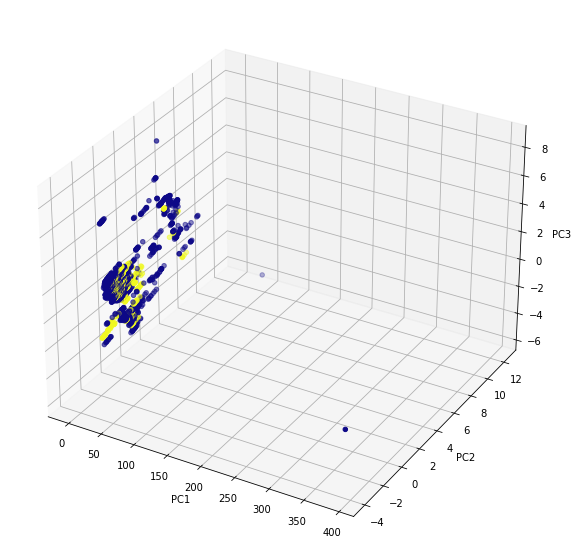

In [ ]:
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=encoded_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

Mesmo com as features menos relevantes removidas, ainda há indecisão na separação, mas vamos testar dessa forma.

### Modelo

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train_dropped, y_train_dropped)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=32642)

### Teste

In [ ]:
model.score(X_test_dropped, y_test_dropped)

0.5218932643479928

In [ ]:
y_pred = model.predict(X_test_dropped)
print(metrics.classification_report(y_test_dropped, y_pred, digits=4))

              precision    recall  f1-score   support

           A     0.4845    0.9587    0.6437      4286
           B     1.0000    0.4000    0.5714         5
           C     0.0000    0.0000    0.0000       103
           D     0.0000    0.0000    0.0000       353
           E     0.5216    0.1215    0.1970      1095
           F     0.1790    0.0209    0.0374      1962
           G     0.0000    0.0000    0.0000       447
           H     0.5075    0.0654    0.1158       520
           I     0.9188    0.8161    0.8644       832
           W     0.1111    0.0222    0.0370        45
           X     0.7243    0.7299    0.7271       522
           Y     0.5583    0.2509    0.3463       267

    accuracy                         0.5219     10437
   macro avg     0.4171    0.2821    0.2950     10437
weighted avg     0.4373    0.5219    0.4124     10437



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


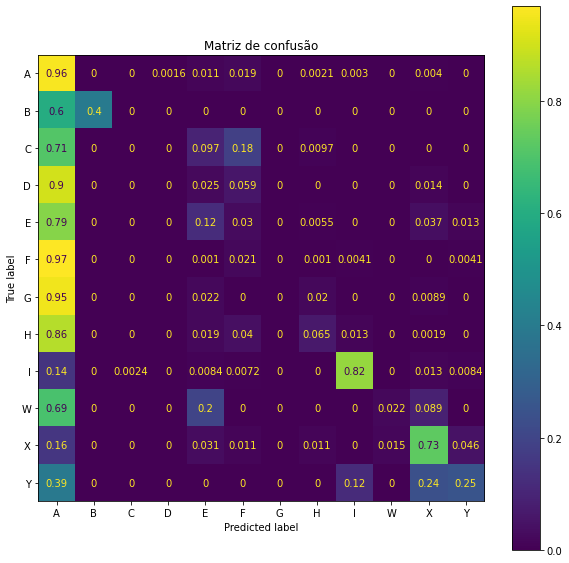

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test_dropped, y_pred,normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Não foi possível obter melhorias no modelo removendo algumas colunas, principalmente devido ao desbalanceamento do dataset. Assim, vamos tentar mesclar as abordagens: reduzir o número de casos e remover features menos importantes.

## Modelo com mudança nas colunas e no balanceamento do dataset

Para este modelo, vamos reduzir o número de exemplos das classes A e F e remover as colunas menos relevantes para a classificação.

In [ ]:
# Mudanças no dataset
balanced_dataset = avila_train.drop(avila_train.query("Class == 'A'").sample(frac=0.7).index)
balanced_dataset = balanced_dataset.drop(balanced_dataset.query("Class == 'F'").sample(frac=0.5).index)
balanced_dataset.shape

X_train_balanced = balanced_dataset.iloc[:, :-1]
y_train_balanced = balanced_dataset.iloc[:, -1]

### Análise utilizando PCA

Vamos utilizar o PCA novamente para verificar se o dataset balanceado e com colunas removidas consegue uma melhor separação.

In [ ]:
avila_tr_A = balanced_dataset.query("Class == 'A'")
avila_tr_F = balanced_dataset.query("Class == 'F'")
avila_tr_A_F = pd.concat([avila_tr_A, avila_tr_F], axis=0)

X_train_A_F = avila_tr_A_F.iloc[:, :-1]
y_train_A_F = avila_tr_A_F.iloc[:, -1]

Como os dados já estão normalizados, podemos partir para o "fit" e o "transform" no PCA

In [ ]:
principal = PCA(n_components=3)
principal.fit(X_train_A_F)
x = principal.transform(X_train_A_F)
x.shape

(2267, 3)

O número de features foi reduzida para 3. Com o PCA feito, podemos plotar um gráfico para verificar se os componentes principais conseguem separar as classes A e F.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train_A_F)
encoded_labels = le.transform(y_train_A_F)
encoded_labels

array([0, 0, 0, ..., 1, 1, 1])

Text(0, 0.5, 'pc2')

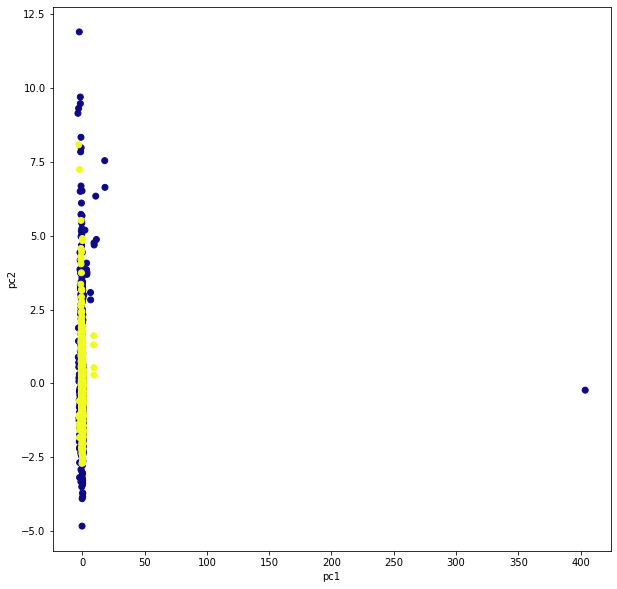

In [ ]:
plt.figure(figsize=(10,10))
colors = np.random.rand(6247)
plt.scatter(x=x[:,0], y=x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

Text(0.5, 0, 'PC3')

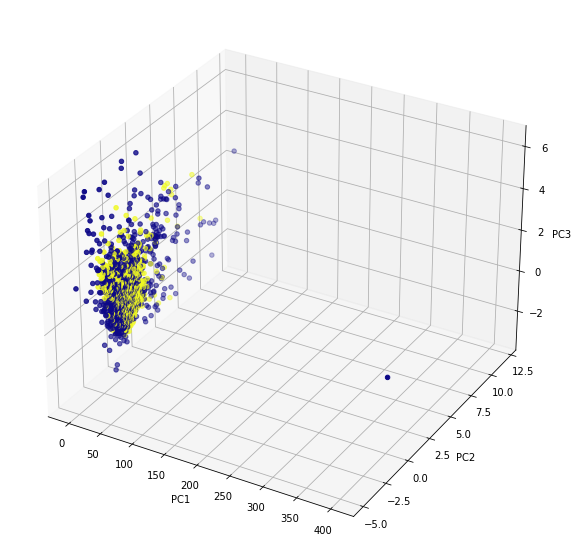

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=encoded_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

Utilizando o PCA foi possível ver que, mesmo utilizando os principais componentes para separar os dados, eles ainda não são bem separáveis. Assim, vamos tentar reduzir o número de features, mantendo as mais relevantes de acordo com o artigo que acompanha o projeto.

### Removendo colunas do dataset

In [ ]:
balanced_dataset_dropped = balanced_dataset.drop(columns=["modular ratio/ interlinear spacing", "weight", "modular ratio", "interlinear spacing"])
avila_ts_dropped = avila_test.drop(columns=["modular ratio/ interlinear spacing", "weight", "modular ratio", "interlinear spacing"])

X_train_dropped = balanced_dataset_dropped.iloc[:, :-1]
y_train_dropped = balanced_dataset_dropped.iloc[:, -1]

X_test_dropped = avila_ts_dropped.iloc[:, :-1]
y_test_dropped = avila_ts_dropped.iloc[:, -1]

### Análise utilizando PCA para dataset com colunas removidas

In [ ]:
avila_tr_A_dropped = balanced_dataset_dropped.query("Class == 'A'")
avila_tr_F_dropped = balanced_dataset_dropped.query("Class == 'F'")
avila_tr_A_F_dropped = pd.concat([avila_tr_A_dropped, avila_tr_F_dropped], axis=0)

X_train_A_F_dropped = avila_tr_A_F_dropped.iloc[:, :-1]
y_train_A_F_dropped = avila_tr_A_F_dropped.iloc[:, -1]

In [ ]:
principal = PCA(n_components=3)
principal.fit(X_train_A_F_dropped)
x = principal.transform(X_train_A_F_dropped)
x.shape

(2267, 3)

O número de features foi reduzida para 3. Com o PCA feito, podemos plotar um gráfico para verificar se os componentes principais conseguem separar as classes A e F.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_train_A_F_dropped)
encoded_labels = le.transform(y_train_A_F_dropped)
encoded_labels

array([0, 0, 0, ..., 1, 1, 1])

Text(0, 0.5, 'pc2')

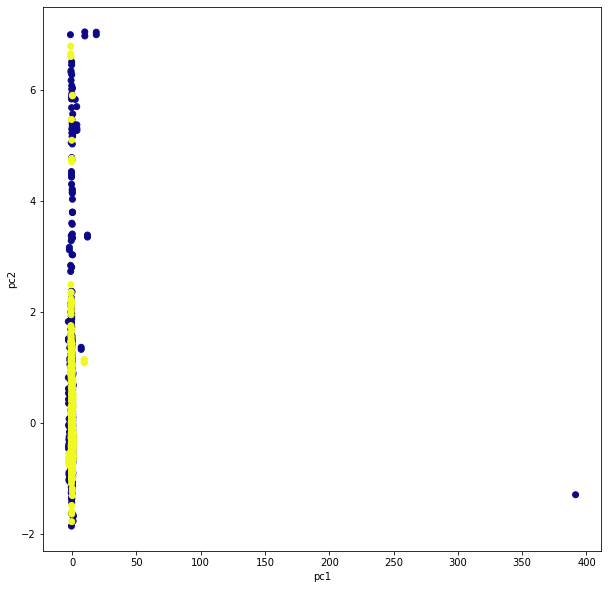

In [ ]:
plt.figure(figsize=(10,10))
colors = np.random.rand(6247)
plt.scatter(x=x[:,0], y=x[:,1], c=encoded_labels, cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

Text(0.5, 0, 'PC3')

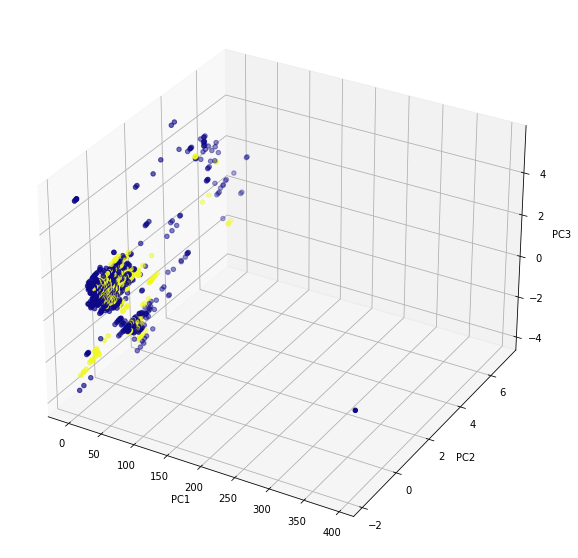

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
 
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
 
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=encoded_labels,cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

Dessa vez é possível ver um grau um pouco maior de separação, principalmente se considerarmos os exemplos que estão mais distantes do bloco que concentra a maioria dos exemplos.

### Modelo

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=SEED)

# Treinamento
model.fit(X_train_dropped, y_train_dropped)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=32642)

### Teste

In [ ]:
model.score(X_test_dropped, y_test_dropped)

0.5093417648749641

In [ ]:
y_pred = model.predict(X_test_dropped)
print(metrics.classification_report(y_test_dropped, y_pred, digits=4))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           A     0.5875    0.6736    0.6276      4286
           B     1.0000    0.4000    0.5714         5
           C     0.0000    0.0000    0.0000       103
           D     0.0000    0.0000    0.0000       353
           E     0.2959    0.6329    0.4033      1095
           F     0.4240    0.2503    0.3147      1962
           G     0.0000    0.0000    0.0000       447
           H     0.2288    0.1404    0.1740       520
           I     0.8195    0.8401    0.8297       832
           W     0.1053    0.0444    0.0625        45
           X     0.6359    0.7663    0.6950       522
           Y     0.4694    0.2584    0.3333       267

    accuracy                         0.5093     10437
   macro avg     0.3805    0.3339    0.3343     10437
weighted avg     0.4735    0.5093    0.4778     10437



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


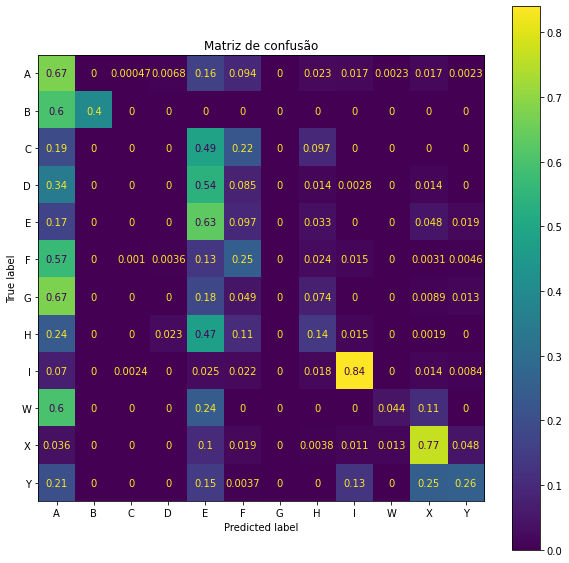

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test_dropped, y_pred,normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Mesmo com as mudanças, não foi possível melhorar a acurácia. Além disso, com menos exemplos no treinamento, o modelo não conseguiu informações suficientes para classificar A e F, o que também contribuiu para piorar a acurácia.

## Modelo feito manualmente

Para este modelo, vamos programar uma classe para realizar uma avaliação "one vs rest".

In [ ]:
class All_datasets:
  def __init__(self, dataset_tr, dataset_ts):
    self.dataset_tr = dataset_tr
    self.dataset_ts = dataset_ts
    self.classes_tr = self.dataset_tr['Class'].unique()
    self.classes_ts = self.dataset_ts['Class'].unique()
    self.datasets_tr = dict()
    self.datasets_ts = dict()
    self.X_train = dict()
    self.y_train = dict()
    self.X_test = dict()
    self.y_test = dict()
    self.models = dict()
  
  def setup_tr(self):
    for classe in self.classes_tr:
      copied_dataset_tr = self.dataset_tr.copy(deep=True)
      copied_dataset_tr.loc[copied_dataset_tr['Class'] == classe, "Class"] = 1
      copied_dataset_tr.loc[copied_dataset_tr['Class'] != 1, "Class"] = 0
      copied_dataset_tr['Class'] = copied_dataset_tr['Class'].astype(int)
      self.datasets_tr[classe] = copied_dataset_tr
  
  def setup_ts(self): 
    for classe in self.classes_ts:
      copied_dataset_ts = self.dataset_ts.copy(deep=True)
      copied_dataset_ts.loc[copied_dataset_ts['Class'] == classe, "Class"] = 1
      copied_dataset_ts.loc[copied_dataset_ts['Class'] != 1, "Class"] = 0
      copied_dataset_ts['Class'] = copied_dataset_ts['Class'].astype(int)
      self.datasets_ts[classe] = copied_dataset_ts

  def setup(self):
    self.setup_tr()
    self.setup_ts()

  def check_dataset_tr(self, classe):
    print(self.datasets_tr[classe])
  
  def check_dataset_ts(self, classe):
    print(self.datasets_ts[classe])

  def split_train_test(self):
    for classe in self.classes_tr:
      X_train = self.datasets_tr[classe].iloc[:, :-1]
      y_train = self.datasets_tr[classe].iloc[:, -1]
      self.X_train[classe] = X_train
      self.y_train[classe] = y_train

    for classe in self.classes_ts:
      X_test = self.datasets_ts[classe].iloc[:, :-1]
      y_test = self.datasets_ts[classe].iloc[:, -1]
      self.X_test[classe] = X_test
      self.y_test[classe] = y_test

  def create_models(self):
    for classe in self.classes_tr:
      self.models[classe] = LogisticRegression(max_iter=1000, random_state=SEED)
  
  def fit(self):
    for classe in self.classes_tr:
      self.models[classe].fit(self.X_train[classe], self.y_train[classe])
  
  def individual_score(self):
    for classe in self.classes_ts:
      print("Classe {cls} teve score: {scr}".format(cls = classe, scr = self.models[classe].score(self.X_test[classe], self.y_test[classe])))

  def predict(self):
    predicted_probas = dict()
    for classe in self.classes_ts:
      predicted_probas[classe] = []
      class_predict_proba = self.models[classe].predict_proba(self.X_test[classe])
      for prob in class_predict_proba:
        predicted_probas[classe].append(prob[1])

    predicted_list = []
    for i in range(len(predicted_probas["A"])):
      predicted = []
      for classe in self.classes_ts:
        predicted.append((classe, predicted_probas[classe][i]))
      predicted_list.append(predicted)
    
    final_predict = []
    for lst in predicted_list:
      final_predict.append(max(lst, key=lambda item:item[1])[0])
    
    return final_predict


### Modelo

In [ ]:
# Setup do modelo
all_datasets = All_datasets(avila_train, avila_test)
all_datasets.setup()
all_datasets.split_train_test()
all_datasets.create_models()

# Treinamento
all_datasets.fit()

### Teste

In [ ]:
all_datasets.individual_score()

Classe W teve score: 0.995688416211555
Classe A teve score: 0.6878413337165852
Classe I teve score: 0.9686691578039667
Classe E teve score: 0.8915397144773403
Classe F teve score: 0.8054038516815176
Classe Y teve score: 0.9764300086231675
Classe H teve score: 0.9499856280540385
Classe D teve score: 0.9661780205039763
Classe G teve score: 0.9571716010347802
Classe X teve score: 0.9754718788924021
Classe C teve score: 0.9901312637731149
Classe B teve score: 0.9998083740538469


Pelos scores, é possível ver que, ao menos a nível individual, os modelos conseguem diferenciar entre exemplos que pertencem às classes e exemplos que não pertencem, realizando uma avaliação binária.

In [ ]:
all_datasets_pred = all_datasets.predict()
print(metrics.classification_report(y_test, all_datasets_pred, digits=4))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           A     0.4957    0.9704    0.6562      4286
           B     1.0000    1.0000    1.0000         5
           C     0.0000    0.0000    0.0000       103
           D     0.0000    0.0000    0.0000       353
           E     0.4032    0.0685    0.1171      1095
           F     0.1923    0.0280    0.0489      1962
           G     0.0000    0.0000    0.0000       447
           H     0.4706    0.0769    0.1322       520
           I     0.8236    0.8810    0.8513       832
           W     0.0000    0.0000    0.0000        45
           X     0.8212    0.6686    0.7371       522
           Y     0.7412    0.4719    0.5767       267

    accuracy                         0.5310     10437
   macro avg     0.4123    0.3471    0.3433     10437
weighted avg     0.4316    0.5310    0.4175     10437



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


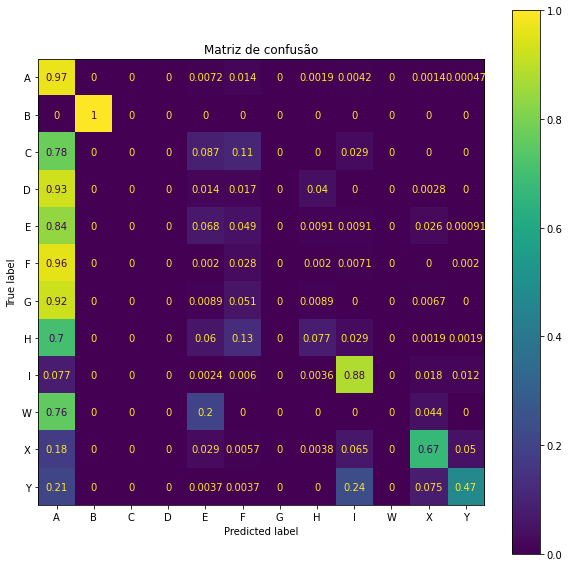

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test, all_datasets_pred, normalize='true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Ainda que os modelos performem bem em avaliações binárias, o resultado permanece ruim quando eles são unidos. Isso pode ter ligação com a forma escolhida para uni-los, já que ela foi feita escolhendo como classe final aquela que possui maior probabilidade. Além disso, pelos scores individuais, é possível perceber que as classes que possuem mais exemplos (A, E e F) são as que têm menor score, o que indica que o número de casos pode estar introduzindo um viés na classificação dos exemplos.

## Grid search com pesos

In [ ]:
w = [{'A': 1, 'B': 857, 'C': 219, 'D': 104, 'E': 21, 'F': 9, 'G': 104, 'H': 89, 'I': 53, 'W': 392, 'X': 70, 'Y': 166},
     {'A': 0.1, 'B': 85.7, 'C': 21.9, 'D': 10.4, 'E': 2.1, 'F': 0.9, 'G': 10.4, 'H': 8.9, 'I': 5.3, 'W': 39.2, 'X': 7.0, 'Y': 16.6},
     {'A': 1, 'B': 6, 'C': 5, 'D': 4, 'E': 2, 'F': 1, 'G': 4, 'H': 4, 'I': 3, 'W': 5, 'X': 4, 'Y': 5},
     {'A': 1, 'B': 1, 'C': 10, 'D': 10, 'E': 5, 'F': 4, 'G': 10, 'H': 10, 'I': 1, 'W': 10, 'X': 4, 'Y': 5},
     {'A': 1, 'B': 1, 'C': 40, 'D': 12, 'E': 3, 'F': 2, 'G': 10, 'H': 8, 'I': 2, 'W': 10, 'X': 4, 'Y': 10},
     {'A': 1.5, 'B': 1, 'C': 50, 'D': 12, 'E': 3, 'F': 3, 'G': 8, 'H': 6, 'I': 2, 'W': 10, 'X': 4, 'Y': 10}]
parameters = {'multi_class': ["ovr", "multinomial"], 'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], "class_weight": w }
log_reg = LogisticRegression(max_iter=1000, random_state=SEED)
log_reg_cv = GridSearchCV(estimator=log_reg, param_grid=parameters, cv=5, n_jobs=-1, scoring=['precision_macro','recall_macro','f1_macro'], refit=False)
log_reg_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, random_state=2022),
             n_jobs=-1,
             param_grid={'class_weight': [{'A': 1, 'B': 857, 'C': 219, 'D': 104,
                                           'E': 21, 'F': 9, 'G': 104, 'H': 89,
                                           'I': 53, 'W': 392, 'X': 70,
                                           'Y': 166},
                                          {'A': 0.1, 'B': 85.7, 'C': 21.9,
                                           'D': 10.4, 'E': 2.1, 'F': 0.9,
                                           'G': 10.4, 'H': 8.9, 'I': 5.3,
                                           'W': 39.2, 'X': 7.0, 'Y': 16.6},
                                          {'A': 1, 'B': 6, 'C': 5, 'D': 4,
                                           'E': 2, 'F': 1, '...
                                           'E': 5, 'F': 4, 'G': 10, 'H': 10,
                                           'I': 1, 'W': 10, 'X': 4, 'Y': 5},
                                          {'A': 1, 'B': 1, 'C': 40, 'D': 12,
                                           'E': 3, 'F': 2, 'G': 10, 'H': 8,
                                           'I': 2, 'W': 10, 'X': 4, 'Y': 10},
                                          {'A': 1.5, 'B': 1, 'C': 50, 'D': 12,
                                           'E': 3, 'F': 3, 'G': 8, 'H': 6,
                                           'I': 2, 'W': 10, 'X': 4, 'Y': 10}],
                         'multi_class': ['ovr', 'multinomial'],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
             refit=False,
             scoring=['precision_macro', 'recall_macro', 'f1_macro'])

In [ ]:
results_df = pd.DataFrame(log_reg_cv.cv_results_)
results_df[['mean_test_f1_macro','mean_test_recall_macro','mean_test_precision_macro', 'params']]

,mean_test_f1_macro,mean_test_recall_macro,mean_test_precision_macro,params
0,0.290146,0.456200,0.274448,"{'class_weight': {'A': 1, 'B': 857, 'C': 219, ..."
1,0.290146,0.456200,0.274448,"{'class_weight': {'A': 1, 'B': 857, 'C': 219, ..."
2,0.280530,0.421060,0.270390,"{'class_weight': {'A': 1, 'B': 857, 'C': 219, ..."
3,0.283512,0.425973,0.263275,"{'class_weight': {'A': 1, 'B': 857, 'C': 219, ..."
4,0.324040,0.505153,0.370468,"{'class_weight': {'A': 1, 'B': 857, 'C': 219, ..."
5,0.324040,0.505153,0.370468,"{'class_weight': {'A': 1, 'B': 857, 'C': 219, ..."
6,0.315139,0.487369,0.365524,"{'class_weight': {'A': 1, 'B': 857, 'C': 219, ..."
7,0.317092,0.496693,0.365101,"{'class_weight': {'A': 1, 'B': 857, 'C': 219, ..."
8,0.289952,0.455962,0.274185,"{'class_weight': {'A': 0.1, 'B': 85.7, 'C': 21..."
9,0.289952,0.455962,0.274185,"{'class_weight': {'A': 0.1, 'B': 85.7, 'C': 21..."


Utilizando o F1-score como parâmetro para comparação entre modelos, é possível ver que o maior resultado foi 0.46927, obtido pelo modelo com parâmetros {'class_weight': {'A': 1.5, 'B': 1, 'C': 50, 'D': 12, 'E': 3, 'F': 3, 'G': 8, 'H': 6, 'I': 2, 'W': 10, 'X': 4, 'Y': 10}, 'multi_class': 'multinomial', 'solver': 'newton-cg'}.

## Modelo com os melhores pesos

In [ ]:
# Setup do modelo
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=1000, random_state=SEED, class_weight= {'A': 1.5, 'B': 1, 'C': 50, 'D': 12, 'E': 3, 'F': 3, 'G': 8, 'H': 6, 'I': 2, 'W': 10, 'X': 4, 'Y': 10})

# Treinamento
model.fit(X_train, y_train)

LogisticRegression(class_weight={'A': 1.5, 'B': 1, 'C': 50, 'D': 12, 'E': 3,
                                 'F': 3, 'G': 8, 'H': 6, 'I': 2, 'W': 10,
                                 'X': 4, 'Y': 10},
                   max_iter=1000, multi_class='multinomial', random_state=32642,
                   solver='newton-cg')

### Teste

In [ ]:
model.score(X_test, y_test)

0.5062757497365143

In [ ]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           A     0.6750    0.5642    0.6146      4286
           B     1.0000    1.0000    1.0000         5
           C     0.0553    0.5340    0.1002       103
           D     0.2157    0.3116    0.2549       353
           E     0.6621    0.2630    0.3765      1095
           F     0.3816    0.4419    0.4095      1962
           G     0.2054    0.1879    0.1963       447
           H     0.3475    0.3308    0.3389       520
           I     0.9489    0.8486    0.8959       832
           W     0.0986    0.1556    0.1207        45
           X     0.6829    0.6973    0.6900       522
           Y     0.5389    0.7790    0.6371       267

    accuracy                         0.5063     10437
   macro avg     0.4843    0.5095    0.4696     10437
weighted avg     0.5768    0.5063    0.5270     10437



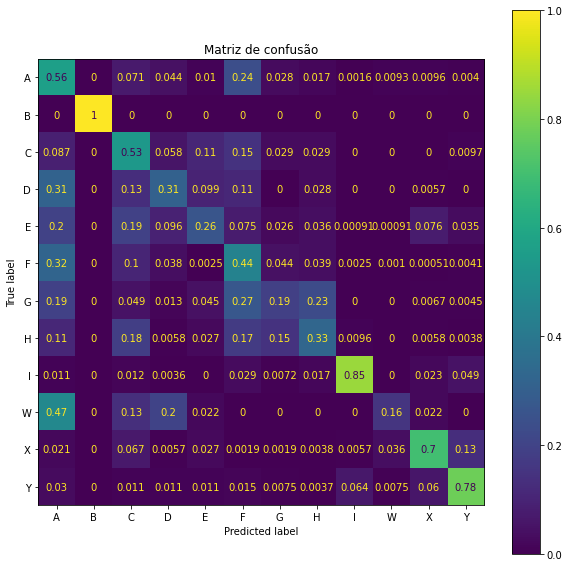

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")
conf_mat = metrics.confusion_matrix(y_test, y_pred, normalize="true")
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(ax=ax)
plt.show()

### Conclusão

Este foi o modelo com melhor F1-score dentre todos os testados. Ainda assim, não foi possível encontrar um modelo com resultados satisfatórios.

## Conclusão geral

Ainda que os modelos performem bem em avaliações binárias, o resultado permanece ruim quando eles são unidos. Isso pode ter ligação com a forma escolhida para uni-los, já que ela foi feita escolhendo como classe final aquela que possui maior probabilidade. Além disso, pelos scores individuais, é possível perceber que as classes que possuem mais exemplos (A, E e F) são as que têm menor score, o que indica que o número de casos pode estar introduzindo um viés na classificação dos exemplos.

# Classificação usando kNN

## Bibliotecas usadas:
- scikit-learn
  - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- pandas

  O KNN é um modelo de aprendizado de máquina que se baseia na distância entre os elementos para realizar sua classificação. Sendo assim, esse modelo tem uma melhor performance em datasets nos quais as classes estão bem separadas. Contudo, como visto no PCA realizado anteriormente, existem classes não bem separadas, o que pode afetar o desempenho do modelo.
 Fixaremos a distância euclidiana e tentaremos encontrar um valor de K que maximize as métricas em análise. 


## Modelo Base

Antes de tentar encontrar o melhor parâmetro k para o modelo, iremos treinar um modelo mais básico com k=3. Dessa forma, poderemos perceber o ganho de desempenho ocasioando por uma seleção mais cuidadosa do parâmetro.

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
train_score = model_knn.score(X_train,y_train)
test_score  = model_knn.score(X_test, y_test)

print('train score: ', train_score)
print('test score: ', test_score)

train score:  0.8701821668264621
test score:  0.7578806170355467


Espera-se que o modelo após a seleção do melhor K tenha um desempenho melhor que a do modelo base, com isso percebemos que, ao contrário do que esperavamos, o KNN consegue lidar relativamente bem em realizar a classificação.  
 Como é esperado que a acurácia não caia para abaixo do modelo base, percebe-se que o KNN se sai relativamente bem na tarefa dada embora hajam classes não bem definidas

## Escolhendo os Melhores Parâmetros

 Para alcançar melhores resultados, buscaremos o valor de K que traz os melhores resultados para o modelo. Exploraremos os resultados de F1-Score, Precision e Recall de modelos sobre um conjunto de valores entre 1 e 50. Para essa tarefa, usaremos o GridSearch, que faz uma busca exaustiva no espaço de valores usando validação cruzada, eliminando a necessidade de se separar uma parte do conjunto de treino para realizar a validação do modelo.

In [ ]:
k_values = range(1,50)
scores = ['precision_macro','recall_macro','f1_macro']

In [ ]:
gs = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={'n_neighbors': k_values},
    scoring=scores,
    n_jobs=-1,
    refit=False,
    return_train_score=True,
    cv=5
)

gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 50)}, refit=False,
             return_train_score=True,
             scoring=['precision_macro', 'recall_macro', 'f1_macro'])

### Análise

In [ ]:
results_df = pd.DataFrame(gs.cv_results_)

results_df.index = k_values

results_df[['mean_train_f1_macro','mean_test_f1_macro',
            'mean_train_recall_macro','mean_test_recall_macro',
            'mean_train_precision_macro','mean_test_precision_macro']].head()

,mean_train_f1_macro,mean_test_f1_macro,mean_train_recall_macro,mean_test_recall_macro,mean_train_precision_macro,mean_test_precision_macro
1,1.000000,0.739940,1.000000,0.720784,1.000000,0.766803
2,0.855714,0.688949,0.813584,0.638692,0.921477,0.780746
3,0.851243,0.709752,0.813864,0.665920,0.897390,0.777080
4,0.815066,0.677423,0.763060,0.627618,0.888523,0.765071
5,0.795160,0.672633,0.743996,0.624549,0.871533,0.756873


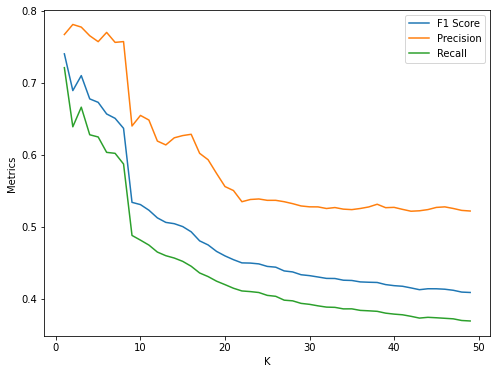

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))

ax.set_xlabel('K')
ax.set_ylabel('Metrics')

ax.plot(k_values, gs.cv_results_['mean_test_f1_macro'], label='F1 Score')
ax.plot(k_values, gs.cv_results_['mean_test_precision_macro'], label='Precision',)
ax.plot(k_values, gs.cv_results_['mean_test_recall_macro'], label='Recall',)

ax.legend()
plt.show()

 Pelo gráfico acima, percebe-se que todas as métricas se comportam de maneira bastante similar ao longo dos valores de K analisados.
 Percebe-se que os melhores valores de K estão mais à esquerda, sendo aqueles com menor magnitude. É válido ressaltar a queda brusca em todas as métricas que há a no ponto onde K=8. 

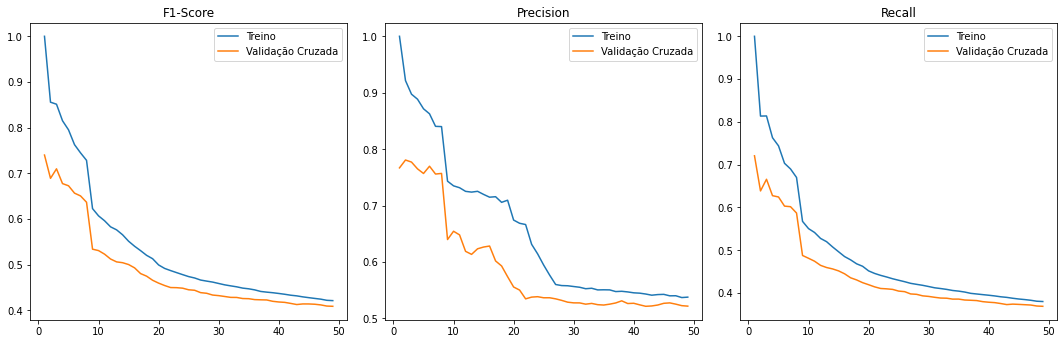

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(k_values,gs.cv_results_['mean_train_f1_macro'])
ax[0].plot(k_values,gs.cv_results_['mean_test_f1_macro'])

ax[1].plot(k_values,gs.cv_results_['mean_train_precision_macro'])
ax[1].plot(k_values,gs.cv_results_['mean_test_precision_macro'])

ax[2].plot(k_values,gs.cv_results_['mean_train_recall_macro'])
ax[2].plot(k_values,gs.cv_results_['mean_test_recall_macro'])

for i in range(0,3):
  ax[i].legend(('Treino','Validação Cruzada'))

ax[0].set_title('F1-Score')
ax[1].set_title('Precision')
ax[2].set_title('Recall')

fig.tight_layout(pad=1.5)
plt.show()

Observando os gráficos e a tabela de valores, percebemoes que para o valor K=1, o modelo sofria overffiting uma vez que possuia resultados perfeitos no treinamento. Sendo assim, evitaremos esse valor na escolha do melhor parâmetro, além do fato de um modelo KNN com K=1 ter uma baixa robustez.
  Sendo assim, o melhor valor de K para o modelo é 3. Por coincidência, o mesmo que testamos no modelo base.

In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=3)
best_knn.fit(X_train,y_train)

y_pred = best_knn.predict(X_test)

c_report = classification_report(y_test,y_pred, digits=4)
print(c_report)

              precision    recall  f1-score   support

           A     0.7402    0.8600    0.7956      4286
           B     1.0000    1.0000    1.0000         5
           C     0.6164    0.4369    0.5114       103
           D     0.7358    0.5524    0.6311       353
           E     0.7894    0.6502    0.7131      1095
           F     0.6645    0.6651    0.6648      1962
           G     0.7078    0.5257    0.6033       447
           H     0.7360    0.5308    0.6168       520
           I     0.9669    0.9471    0.9569       832
           W     1.0000    0.6000    0.7500        45
           X     0.9375    0.8333    0.8824       522
           Y     0.8553    0.7528    0.8008       267

    accuracy                         0.7579     10437
   macro avg     0.8125    0.6962    0.7438     10437
weighted avg     0.7603    0.7579    0.7541     10437



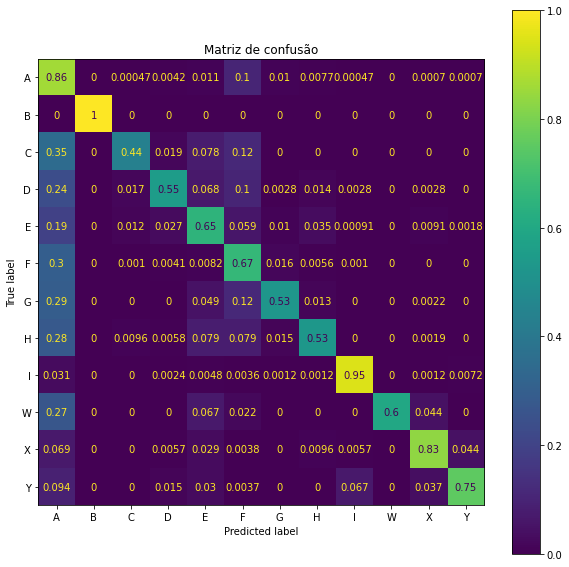

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Matriz de confusão")

cm = confusion_matrix(y_test, y_pred, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm_display.plot(ax=ax)
plt.show()


#### Conclusão
 Percebe-se que o KNN obteve uma performance razoável em solucionar o problema. Como pode ser visto na matriz de confusão, o modelo constantemente prediz a classe A, mesmo quando ela não é a correta, provavelmente pelo fato dessa classe possuir a maior quantidade de exmplos.  
 Nota-se também que o modelo se sai melhor em classificar algumas classes do que outras. A classe B tem seus exemplos do teste perfeitamente classificados enquanto que a o modelo falha em classificar exemplos de C mais do que metade das vezes.


# Resultados dos modelos

In [ ]:
metrics = ["F1-Score", "Precision", "Recall", "Accuracy"]

#                                             F1   Prec.   Recall  Accuracy   
comparison_dict = {'Decision tree':       [0.9813, 0.9813, 0.9815, 0.9875],
                   'Naive Bayes':         [0.3572, 0.3665, 0.4698, 0.2933],
                   'Logistic Regression': [0.4696, 0.4843, 0.5095, 0.5063],
                   'KNN':                 [0.7468, 0.8125, 0.6962, 0.7579]}

model_metrics = pd.DataFrame.from_dict(comparison_dict, orient='index',columns=metrics)
model_metrics

,F1-Score,Precision,Recall,Accuracy
Decision tree,0.9813,0.9813,0.9815,0.9875
Naive Bayes,0.3572,0.3665,0.4698,0.2933
Logistic Regression,0.4696,0.4843,0.5095,0.5063
KNN,0.7468,0.8125,0.6962,0.7579


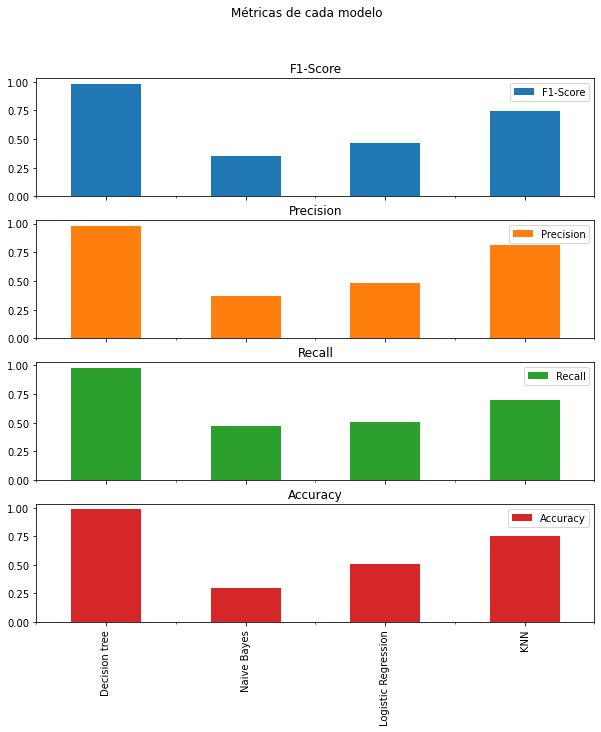

In [ ]:
model_metrics.plot(kind='bar',
                   subplots=True,
                   figsize=(10,10),
                   title= "Métricas de cada modelo");

É perceptível que o modelo usando Árvores de Decisão superão todos os demais modelos nas métricas dadas pelo fato do mesmo não assumir uma distribuição dos dados.  
O KNN ocupou o segundo lugar, obtendo métricas razoáveis embora hajam classes muito semelhantes.  
A Regressão Logística e o Naive Bayes ficaram em 3º e 4º lugar, devido ao desbalanceamento do dataset e a semelhança entre as classes.

# Referências

- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/grid_search.html#grid-search
- https://scikit-learn.org/stable/modules/model_evaluation.html#multimetric-scoring
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
- https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#989c
- https://satishgunjal.com/multiclass_lr_sklearn/#2020
- https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://builtin.com/machine-learning/logistic-regression-classification-algorithm
- https://www.statology.org/pandas-drop-rows-with-condition/
- https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/
- https://towardsdatascience.com/the-perfect-recipe-for-classification-using-logistic-regression-f8648e267592